# Pseudotemporal ordering

(trajectories-pseudotemporal-key-takeaway-1)=
## Motivation

Single-cell sequencing assays provide high-resolution measurements of biological tissues {cite}`Islam2011`, {cite}`Hwang2018`.
Consequently, such technologies can help decipher and understand cellular heterogeneity {cite}`Briggs2018`, {cite}`pt:Sikkema2022` and the dynamics of a biological process {cite}`Jardine2021`, {cite}`He2022_fetal_lung`.\
Corresponding studies include quantifying cellular fates and identifying genes that drive the process.
However, as cells are destroyed when sequenced in classical single-cell RNA sequencing (scRNA-seq) protocols, it is impossible to track their development and, for example, gene expression profile over time.
Although recent technological advances enable the sequential recording of the transcriptome {cite}`Chen2022`, they are experimentally challenging and currently fail to scale to larger datasets.
Consequently, the underlying dynamic process needs to be estimated from the measured snapshot data instead.

Although samples are traditionally taken from a single experimental time point, a variety of cell types can be observed.
This diversity stems from the asynchronous nature of biological processes.
As such, a range of the developmental process can be observed.
Reconstructing the developmental landscape is the goal of the field, which is referred to as trajectory inference (TI).
This task is achieved by ordering the observed cellular states according to the developmental process.
States are aligned along the developmental direction by mapping discrete annotations to a continuous domain - the so-called _pseudotime_.

Pseudotimes rank cells relative to each other according to their respective stage in the developmental process.
Less mature cells are assigned small values, while mature cells are assigned large values.
Studying a bone marrow sample, for example, hematopoietic stem cells are assigned a low pseudotime, and erythroid cells a high pseudotime.
The assignment, in the case of single-cell RNA sequencing data, is based on the transcriptomic profile of a single cell.
Additionally, the construction usually requires the specification of an initial, or equivalently, a root cell, where the overall process begins.

(trajectories-pseudotemporal-key-takeaway-2)=
## Pseudotime construction

Pseudotime construction generally follows a common workflow: As a first step, the ultra-high-dimensional single-cell data is projected onto a lower-dimensional representation.
This procedure is justified by the observation that dynamical processes progress on a low-dimensional manifold {cite}`pt:Wagner2016`.
In practice, pseudotime methods may rely on principal components (for example, Palantir {cite}`Setty2019`) or diffusion components (for example, diffusion pseudotime (DPT) {cite}`Haghverdi2016`).
Following, pseudotimes are constructed based on one of the following principles.

1. Observations are first clustered and, following, connections between these clusters are identified.
The clusters can be ordered, and thereby, a pseudotime can be constructed.
Henceforth, we will refer to this approach as the _cluster approach_.
Classical cluster algorithms include $k$-means {cite}`Lloyd1982`, {cite}`MacQueen1967`, Leiden {cite}`pt:Traag2019`, or hierarchical clustering {cite}`Mueller2011`.
Clusters may be connected based on similarity, or by constructing a minimum spanning tree (MST) {cite}`Pettie2002`.

2. The _graph approach_ first finds connections between the lower-dimensional representation of the observations.
This procedure defines a graph based on which clusters are defined, and thus an ordering is established.
*PAGA* {cite}`Wolf2019`, for example, partitions the graph into Leiden clusters and estimates connections between them.
Intuitively, this approach preserves the global topology of the data while analyzing it at a lower resolution.
Consequently, the computational efficiency is increased.

3. *Manifold-learning based approaches* proceed similar to the *cluster approach*.
However, connections between clusters are defined by using principal curves or graphs to estimate the underlying trajectories.
Principal curves find a one-dimensional curve that connects cellular observations in the higher-dimensional space.
A notable representation of this approach is Slingshot {cite}`Street2018`.

4. Probabilistic frameworks assign transition probabilities to ordered cell-cell pairs.
Each transition probability quantifies the likelihood that the reference cell is the ancestor of the other cell.
These probabilities define random processes that are used to define a pseudotime.
DPT (Diffusion Pseudotime), for example, is defined as the difference between consecutive states of a random walk.
Contrastingly, Palantir {cite}`Setty2019` models trajectories as Markov chains themselves.
While both approaches rely on a probabilistic framework, they require a root cell to be specified.
The pseudotime itself is computed with respect to this cell.

Trajectory inference (TI) is a well-studied field providing a rich set of methods.
To apply the appropriate method for analyzing a single-cell dataset, it is essential to understand the biological process itself.
This understanding especially includes the nature of the process, *i.e.*, if it, for example, is linear, cyclic, or branching.
Similarly, orthogonal processes within the same dataset limit the TI methods applicable.
To help identify appropriate tools, dynguidelines {cite}`Deconinck2021` provides an exhaustive overview of algorithms and their characteristics.

```{admonition} Orthogonal process in single-cell transcriptomics
:class: dropdown
insert explanation
```

## Down-stream tasks and outlook

Although TI and pseudotime can already provide valuable insights, they typically serve as a stepping stone for more fine-grained analysis.
Identifying terminal states, for example, is a classical biological question that can be studied.
Similarly, lineage bifurcation and {term}`driver genes <Driver genes>` can be identified based on TI and pseudotime.
Which question can be answered, and how the answer is found, is usually method-specific.
Palantir {cite}`Setty2019`, for example, identifies terminal states as absorbing states of its constructed Markov chain.

The success of trajectory inference is well-documented, and consequently, many methods have been proposed.
However, with the advances of sequencing technologies, new sources of information have become available.
ATAC-seq {cite}`Buenrostro2015`, CITE-seq {cite}`pt:Stoeckius2017`, and DOGMA-seq {cite}`pt:Mimitou2021`, for example, measure additional modalities beyond the transcriptome.
Lineage tracing {cite}`Weinreb2020` and metabolic labeling {cite}`Erhard2019`, {cite}`Battich2020`, {cite}`Qiu2020`, {cite}`Erhard2022` even provide the (likely) future state of a given cell.
Consequently, future TI tools will be able to include more information to estimate trajectories and pseudotime more accurately and robustly, allowing for the answer to novel questions.
For example, RNA velocity {cite}`LaManno2018`, {cite}`Bergen2020`, {cite}`Bergen2021` is one technique that uses unspliced and spliced {term}`mRNA <Messenger RNA (mRNA)>` to infer directed, dynamic information beyond classical, static snapshot data.

## Inferring pseudotime for adult human bone marrow

To demonstrate how a pseudotime can be constructed and how different pseudotimes can be compared, we analyze a dataset of adult human bone marrow {cite}`Setty2019`.

### Environment setup

In [1]:
import lamindb as ln
import scanpy as sc

assert ln.setup.settings.instance.slug == "theislab/sc-best-practices"

ln.track("5tukHKyz8kFR")

→ connected lamindb: theislab/sc-best-practices
→ loaded Transform('5tukHKyz8kFR0001', key='pseudotemporal.ipynb'), re-started Run('Hfx6ZbLSPyO3msPK') at 2026-01-14 17:24:35 UTC
→ notebook imports: lamindb==2.0.1 scanpy==1.11.5


### Data loading

In [2]:
af = ln.Artifact.connect("theislab/sc-best-practices").get(
    key="trajectory/pseudotemporal.h5ad", is_latest=True
)
adata = af.load()
adata

... synchronizing pseudotemporal.h5ad: 100.0%


AnnData object with n_obs × n_vars = 5780 × 27876
    obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential'
    var: 'palantir'
    uns: 'clusters_colors', 'palantir_branch_probs_cell_types'
    obsm: 'MAGIC_imputed_data', 'X_tsne', 'palantir_branch_probs'
    layers: 'spliced', 'unspliced'

To construct pseudotimes, the data must be preprocessed.
Here, we filter out genes expressed in only a small number of cells (here, at least 20).
Notably, the construction of the pseudotime later on is robust to the exact choice of the threshold.
Following this initial gene filtering, the cell size is normalized, and the counts are log1p-transformed to reduce the effect of outliers.
As usual, we also identify and annotate highly variable genes.
Finally, a nearest neighbor graph is constructed based on which we will define the pseudotime.
The number of principal components is chosen based on the explained variance.

In [3]:
sc.pp.filter_genes(adata, min_counts=20)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)

sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=10)

/Users/seohyon/miniconda3/envs/pseudotemporal/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


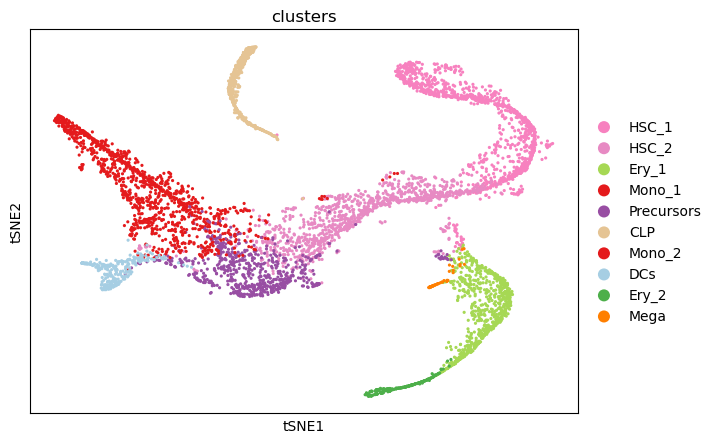

In [4]:
sc.pl.scatter(adata, basis="tsne", color="clusters")

The two-dimensional t-SNE representation colored by cell type annotations shows that the cell types cluster together well.

Additionally, the developmental hierarchy is visible.

### Pseudotime construction

To calculate diffusion pseudotime (DPT), the corresponding diffusion maps must first be calculated.

In [5]:
sc.tl.diffmap(adata)

The differentiation hierarchy in bone marrow is well understood.
However, it is only known that the developmental process starts in the form of hematopoietic stem cells, but not which cell, exactly, in the corresponding cluster in our dataset.
To identify a putative initial cell, we study the individual diffusion components.
We identify the stem cell with the most extreme diffusion component in one dimension (in our case, dimension 3).

```{admonition} Diffusion map and diffusion components
:class: dropdown
*Diffusion map* shows us the non-linear distance between one state of a cell to another.
It is important for this distance to be non-linear, since cells follow a continuous path of gradual changes, rather than "jumping" from one state to another.
Unlike PCA, diffusion map ignores the Euclidean distance and tries to find the curved path the data follows.

*Diffusion components* is the eigenvector of a trnasitioin matrix that represents the "preferred directions" of movement in the diffusion map.
Lower-order diffusion components capture more significant biological transitions.
```

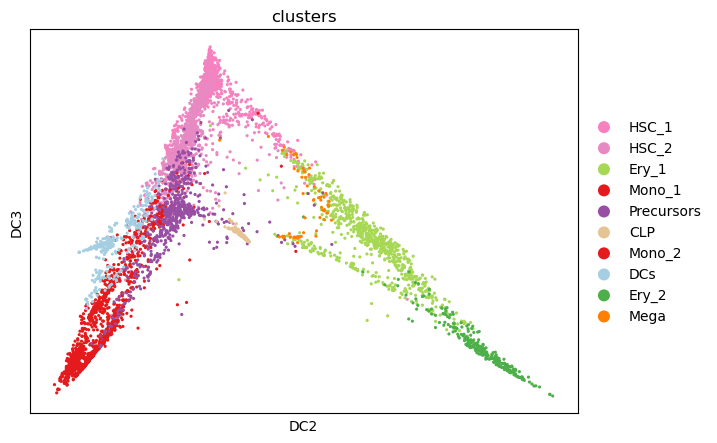

In [6]:
# Setting root cell as described above
root_ixs = adata.obsm["X_diffmap"][:, 3].argmin()
sc.pl.scatter(
    adata,
    basis="diffmap",
    color=["clusters"],
    components=[2, 3],
)

adata.uns["iroot"] = root_ixs

In [7]:
sc.tl.dpt(adata)

Different pseudotime methods give different results.
Sometimes, one pseudotime captures the underlying developmental processes more accurately than others.
Here, we compare the just-computed diffusion pseudotime (DPT) with the pre-computed Palantir pseudotime (see [here](https://github.com/dpeerlab/Palantir/blob/master/notebooks/Palantir_sample_notebook.ipynb) for the corresponding tutorial).
One option for comparing different pseudotimes is to color the low-dimensional embedding of the data (here, t-SNE).
Here, DPT is extremely high in the cluster of CLPs compared to all other cell types.
Contrastingly, the Palantir pseudotime increases continuously with developmental maturity.

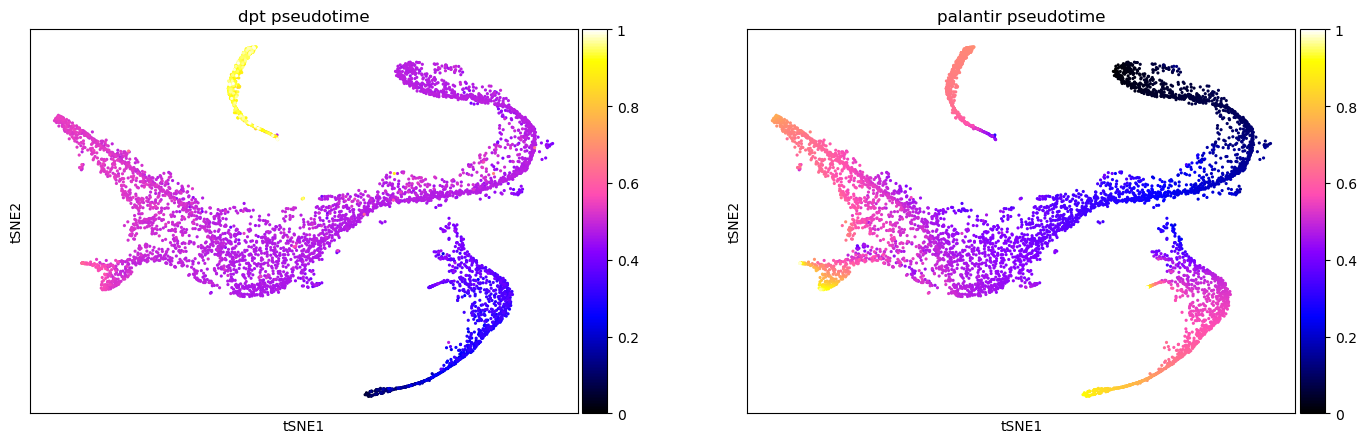

In [8]:
sc.pl.scatter(
    adata,
    basis="tsne",
    color=["dpt_pseudotime", "palantir_pseudotime"],
    color_map="gnuplot2",
)

Instead of coloring the lower-dimensional representation of the data, we can study the distribution of pseudotime values assigned to each cell type cluster.
This representation again shows that the CLP cluster forms an outlier in the case of DPT.
Additionally, clusters such as *HSC_1* and *HSC_2* include several cells with increased pseudotime.
These inflated values contrast with our prior biological knowledge that these clusters form the beginning of the developmental process.

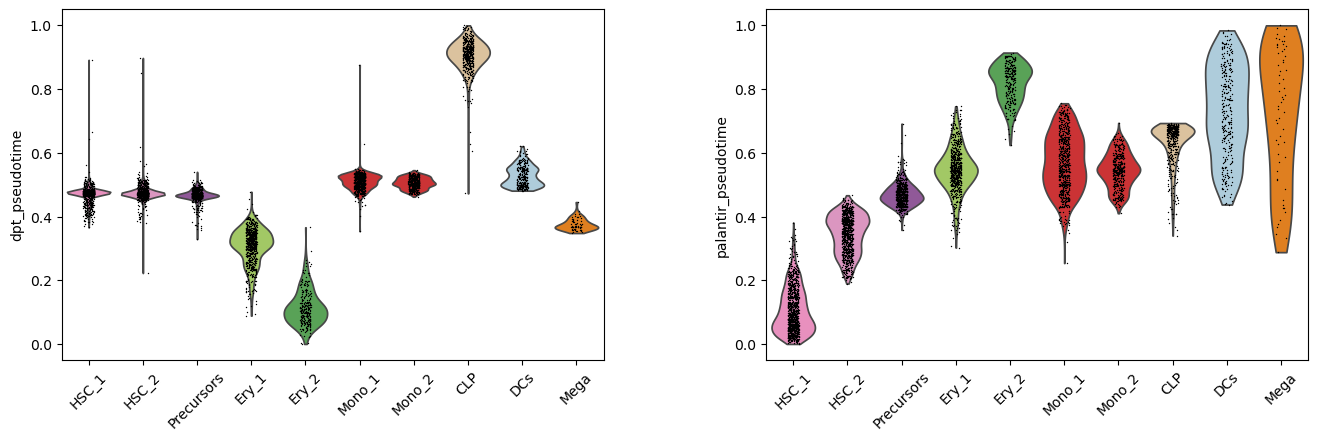

In [9]:
sc.pl.violin(
    adata,
    keys=["dpt_pseudotime", "palantir_pseudotime"],
    groupby="clusters",
    rotation=45,
    order=[
        "HSC_1",
        "HSC_2",
        "Precursors",
        "Ery_1",
        "Ery_2",
        "Mono_1",
        "Mono_2",
        "CLP",
        "DCs",
        "Mega",
    ],
)

Considering these observations and prior knowledge about the development in bone marrow, we would conclude to continue working with the Palantir pseudotime.

## References

```{bibliography}
:filter: docname in docnames
:labelprefix: pt
```

## Contributors

We gratefully acknowledge the contributions of:

### Authors

* Philipp Weiler
* Seo H. Kim

### Reviewers

* Lukas Heumos